<a href="https://colab.research.google.com/github/myke11j/kaggle-competetions/blob/master/Planet%3A%20Understanding%20the%20Amazon%20from%20Space/kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

In [11]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [12]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 597M/600M [00:10<00:00, 78.2MB/s]
100% 600M/600M [00:10<00:00, 60.1MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 56.4MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [14]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)


In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

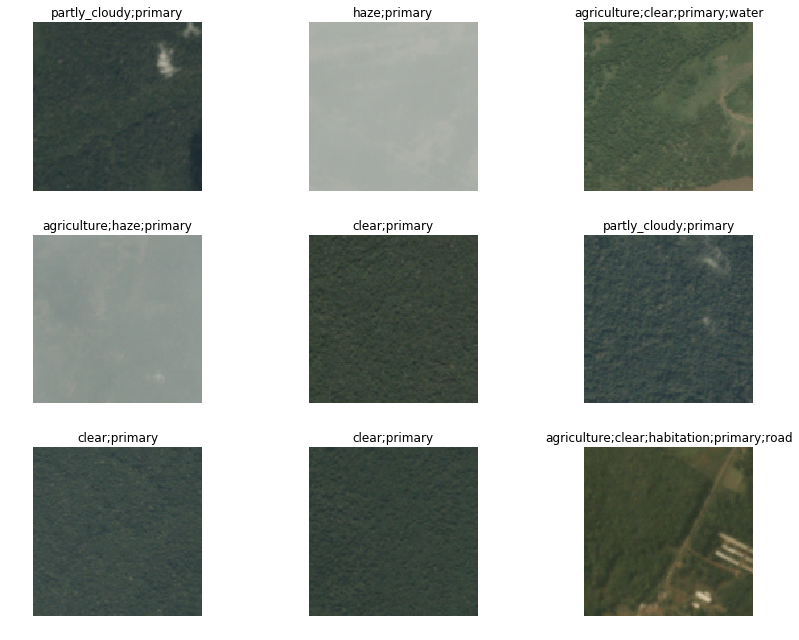

In [18]:
data.show_batch(rows=3, figsize=(12,9))


In [0]:
arch = models.resnet50


In [20]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 99787769.85it/s]


In [21]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


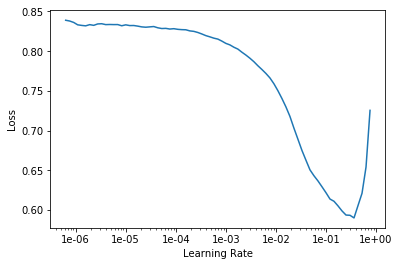

In [22]:
learn.recorder.plot()

In [0]:
lr = 0.01


In [24]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126369,0.109086,0.943088,0.900389,03:44
1,0.107033,0.098524,0.948814,0.913431,03:40
2,0.100365,0.092400,0.948269,0.920229,03:40
3,0.094890,0.088112,0.957628,0.923767,03:41
4,0.093416,0.086982,0.957541,0.925121,03:41


In [0]:
learn.save('stage-1-rn50')


In [0]:
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


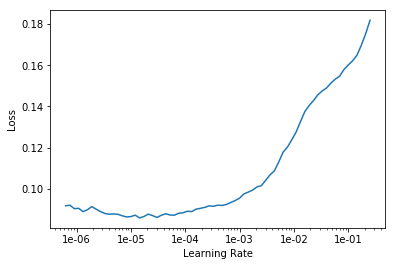

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095567,0.093250,0.954031,0.919450,04:24
1,0.097645,0.089112,0.954860,0.924493,04:24
2,0.090251,0.086603,0.956858,0.925883,04:24
3,0.086858,0.083616,0.957708,0.928588,04:24
4,0.080648,0.082938,0.958704,0.928393,04:24


In [0]:
learn.save('stage-2-rn50')


In [30]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


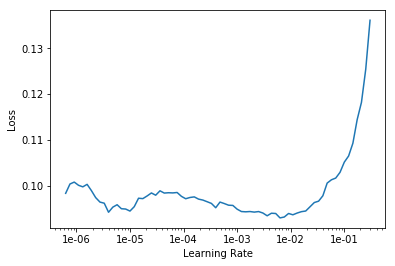

In [32]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2


In [34]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086678,0.086231,0.958943,0.925747,10:38
1,0.086733,0.084117,0.958369,0.928550,10:39
2,0.083175,0.083002,0.957527,0.928756,10:40
3,0.083662,0.081480,0.959329,0.930735,10:41
4,0.080410,0.080976,0.959590,0.930780,10:40


In [0]:
learn.unfreeze()


In [36]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084344,0.083533,0.956916,0.928496,13:54
1,0.087024,0.084203,0.956444,0.926746,13:50
2,0.083484,0.082400,0.957883,0.929444,13:50
3,0.076750,0.080853,0.960121,0.931382,13:51
4,0.074857,0.080574,0.959445,0.931336,13:51


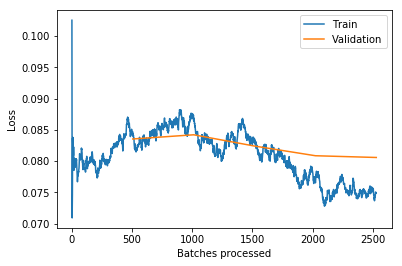

In [37]:
learn.recorder.plot_losses()


In [0]:
learn.save('stage-2-256-rn50')
learn.export()

In [39]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 98% 588M/603M [00:10<00:00, 35.2MB/s]
100% 603M/603M [00:10<00:00, 57.9MB/s]
 98% 299M/304M [00:05<00:00, 60.4MB/s]
100% 304M/304M [00:05<00:00, 61.3MB/s]


In [40]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)


61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [43]:
labelled_preds[:5]


['agriculture cloudy partly_cloudy primary',
 'clear primary',
 'cloudy',
 'clear partly_cloudy primary',
 'clear primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]


In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])


In [0]:
df.to_csv(path/'submission.csv', index=False)


In [47]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "First submission"

100% 2.20M/2.20M [00:13<00:00, 174kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space